In [1]:
#Import necessary packages
import nest_asyncio
nest_asyncio.apply()
import numpy as np
import matplotlib.pyplot as plt
import sklearn.metrics
from sklearn.linear_model import LinearRegression
import pandas as pd
import stan
import subprocess
import warnings
warnings.filterwarnings("ignore")

In [2]:
# The Hawkes process kernel used. Weibull Kernel
def kernel(p, t, beta):
    return (1.0-p)**(t**beta)-(1.0-p)**((t+1)**beta)

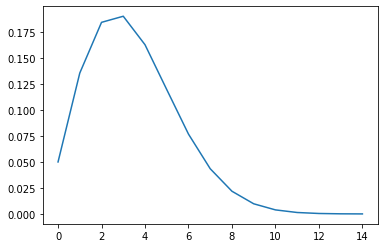

In [3]:
#Plot the Weibull distribution
p = 0.05
beta = 2.0
t = np.zeros(15)
f = np.zeros(15)

for i in range(len(t)):
    f[i] = kernel(p, i, beta)
plt.plot(f)
plt.show()

In [4]:
# Generate Synthetic data from MHP's
M=5
T=300
mu=np.random.rand(M)
mu=mu.reshape((M, 1))

p=0.05
beta=2.0

            
#Set the reproduction matric to have cyclic shape
def create_theta_cycle(d1, d2, M):
    theta=np.zeros([M, M])
    for i in range(M):
        theta[i,i]=d1
        for j in range(M):
            if (np.abs(i-j) % 3) == 1:
                theta[i,j]=d2
    return theta

theta=create_theta_cycle(0.8, 0.05, M)

#SImulate data
def mvh_sim(mu, theta, p, beta, T, M):
    N=np.zeros([M,T])
    lam=np.zeros([M,T])

    for i in range(M):
        lam[i,0]=mu[i]
        N[i,0]=np.random.poisson(lam[i,0])

    for t in range(1,T):
        for i in range(M):
            lam[i,t]=mu[i]
            for j in range(M):
                for s in range(t):
                    lam[i,t]=lam[i,t]+theta[i,j]*kernel(p, t-s-1, beta)*N[j,s]
            N[i,t]=np.random.poisson(lam[i,t])
    return N, lam

N, lam = mvh_sim(mu, theta, p, beta, T, M)

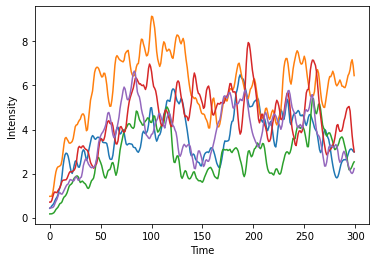

In [5]:
#Plot the simulated intensity
plt.plot(np.transpose(lam))
plt.xlabel('Time')
plt.ylabel('Intensity')
plt.savefig('intensity.eps')
plt.show()

In [6]:
import networkx as nx

#Plotting function for the reproduction matrix graph
def plot_adj_matrix(theta, title, filename = None):
    theta = np.round(theta, decimals=2)
    
    # Shift indices by 1 to start from 1 instead of 0
    theta_shifted = np.pad(theta, ((1, 0), (1, 0)), mode='constant')
    G = nx.from_numpy_array(theta_shifted)
    G.remove_node(0)  # Remove the extra node 0

    self_loops = [(n, n) for n in G.nodes() if G.has_edge(n, n)]
    G.remove_edges_from(self_loops)
    
    
    #G = nx.from_numpy_array(theta)
    pos = nx.circular_layout(G)

    elarge = [(u,v) for (u,v,d) in G.edges(data = True) if d["weight"] > 0.1]
    esmall = [(u,v) for (u,v,d) in G.edges(data=True) if d["weight"] <= 0.1 and d["weight"] > 0.02]

    nx.draw_networkx_nodes(G, pos, node_size=700, node_color='r')
    nx.draw_networkx_edges(G, pos, edgelist=elarge, width = 6)
    nx.draw_networkx_edges(G, pos, edgelist=esmall, width =6 , alpha = 0.5, edge_color='b', style='dashed')

    G1 = G.edge_subgraph(elarge).copy()
    G2 = G.edge_subgraph(esmall).copy()


    nx.draw_networkx_labels(G, pos)
    edge_labels1 = nx.get_edge_attributes(G1, "weight")
    nx.draw_networkx_edge_labels(G1, pos, edge_labels1)
    edge_labels2 = nx.get_edge_attributes(G2, "weight")
    nx.draw_networkx_edge_labels(G2, pos, edge_labels2)

    ax = plt.gca()
    ax.margins(0.08)
    plt.axis("off")
    plt.tight_layout()
    plt.subplots_adjust(top=0.85)
    plt.title(title, size=20)

    if filename !=None:
        plt.savefig(filename +'.eps')
    else:
        plt.show()
        

In [7]:
Naggr=np.sum(N,axis=0)
print(Naggr)

[ 2.  1.  4.  3.  7.  5.  3.  4.  9.  5. 10.  9.  7. 15. 16. 14. 11. 19.
 17. 21. 21. 13. 20. 19. 31. 22. 23. 17. 27. 29. 24. 24. 18. 22. 22. 28.
 20. 18. 14. 28. 19. 23. 22. 24. 19. 26. 27. 22. 28. 28. 26. 18. 21. 18.
 27. 22. 19. 19. 26. 19. 19. 25. 20. 22. 21. 31. 24. 27. 16. 28. 25. 29.
 21. 39. 18. 31. 22. 31. 33. 21. 23. 29. 27. 27. 26. 33. 26. 25. 28. 31.
 30. 37. 30. 17. 24. 32. 30. 20. 32. 26. 20. 26. 23. 27. 23. 29. 23. 31.
 23. 34. 29. 25. 25. 32. 35. 28. 28. 37. 33. 28. 31. 39. 38. 43. 31. 41.
 37. 32. 42. 27. 39. 36. 41. 34. 38. 34. 55. 37. 39. 47. 50. 31. 44. 48.
 39. 36. 31. 35. 38. 33. 37. 35. 39. 31. 37. 40. 38. 48. 37. 47. 45. 32.
 52. 36. 45. 41. 51. 44. 41. 46. 34. 46. 39. 50. 55. 32. 41. 34. 49. 37.
 36. 29. 35. 31. 43. 31. 35. 35. 46. 36. 31. 47. 38. 43. 30. 45. 27. 36.
 38. 35. 36. 37. 32. 42. 39. 39. 33. 48. 42. 45. 51. 41. 45. 49. 51. 52.
 64. 43. 49. 45. 37. 37. 47. 54. 52. 47. 41. 51. 39. 59. 45. 50. 42. 54.
 51. 40. 46. 50. 47. 49. 46. 29. 50. 55. 52. 48. 48

In [8]:
# Stan to estimate p and beta

model = """
data {
int T; //max number of events
real N[T]; // number of events at each time
}

parameters {
real <lower = 0, upper = 1> p;
real <lower = 0> mu;
real <lower = 0, upper = 1> theta;
real <lower = 0> beta;
}

transformed parameters {

vector[T] lam;

lam[1] = mu;

for (i in 2:T){
lam[i] = mu;
    for (j in 1: (i-1)){
    lam[i] += theta*N[j]*(pow(1-p, pow(i-j-1, beta)) - pow(1-p,pow(i-j, beta)));
    }
    }
}

model {
theta ~ beta(1,1);
p ~ beta(1,1);
mu ~ cauchy(0,5);
beta ~ cauchy(0,5);

for (i in 1:T){
target+= N[i]*log(lam[i]) - lam[i];
}
}
"""

In [12]:
data = {"T":300,"N": Naggr}
posterior = stan.build(model, data=data, random_seed=1)
fit = posterior.sample(num_chains=1, num_samples = 1000)

Building: found in cache, done.
Messages from stanc:
Warning in '/tmp/httpstan_u3t33314/model_vp766d7o.stan', line 4, column 0: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.33.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Sampling:   0%
Sampling:   0% (1/2000)
Sampling:   5% (100/2000)
Sampling:  10% (200/2000)
Sampling:  15% (300/2000)
Sampling:  20% (400/2000)
Sampling:  25% (500/2000)
Sampling:  30% (600/2000)
Sampling:  35% (700/2000)
Sampling:  40% (800/2000)
Sampling:  45% (900/2000)
Sampling:  50% (1000/2000)
Sampling:  50% (1001/2000)
Sampling:  55% (1100/2000)
Sampling:  60% (1200/2000)
Sampling:  65% (1300/2000)
Sampling:  70% (1400/2000)
Sampling:  75% (1500/2000)
Sampling:  80% (1600/2000)
Sampling:  85% (1700/2000)
Sampling:  90% (1800/2000)
Sampling:  95% (1900/2000)
Sampling: 100% (2000/2000)
Sampling: 100% (2000/2000), 

In [13]:
p_est = np.mean(fit['p'])
beta_est = np.mean(fit['beta'])

In [14]:
print('{:.3f}'.format(p_est), ['{:.3f}'.format(np.percentile(fit['p'], 5)), '{:.3f}'.format(np.percentile(fit['p'],95))])
print('{:.3f}'.format(beta_est), ['{:.3f}'.format(np.percentile(fit['beta'], 5)), '{:.3f}'.format(np.percentile(fit['beta'],95))])

0.079 ['0.026', '0.157']
1.807 ['1.316', '2.377']


In [16]:
p_est = 0.079
beta_est = 1.807

In [5]:
# Create linear regression from the multivariate Hawkes

def exact_theta(theta, mu):
    M = np.shape(theta)[0]
    theta_vect = np.ones(M*(M+1))
    
    for i in range(M):
        theta_vect[i] = mu[i] #fill the first M elements of the vector 
    cnt = i  #set the cnt value to the last increment of the last loop
    
    for i in range(M):
        for j in range(M):
            cnt+=1
            theta_vect[cnt] = theta[i,j]
    
    return theta_vect

def coef_vec2mat(theta_vect, M):
    theta_est = np.zeros([M,M])
    mu_est = np.zeros(M)
    for i in range(M):
        mu_est[i] = theta_vect[i]
    cnt = i
    for i in range(M):
        for j in range(M):
            cnt+=1
            theta_est[i,j] = theta_vect[cnt]
    return mu_est, theta_est

def create_linear_system(N, p_est, beta_est):
    M = np.shape(N)[0]
    T = np.shape(N)[1]
    y = np.zeros(M*T)
    X = np.zeros([M*T, M*(M+1)])
    cnt = -1
    for t in range(T):
        cnt2 = M-1
        for i in range(M):
            cnt+=1
            y[cnt] = N[i,t]
            X[cnt,i] = 1.0
            for j in range(M):
                cnt2+=1
                for s in range(t):
                    X[cnt, cnt2] += N[j,s]*kernel(p_est, t-s-1, beta_est)
    return y, X

def create_linear_system_diag(N, p_est, beta_est):
    T = len(N)
    y = np.zeros(T)
    X = np.zeros([T,2])
    for t in range(T):
        y[t] = N[t]
        X[t,0] = 1.0
        for s in range(t):
            X[t,1] += N[s]*kernel(p_est, t-s-1, beta_est)
    return y, X

def create_linear_system_fixdiag(N, p_est, beta_est, theta_diag):
    M = np.shape(N)[0]
    T = np.shape(N)[1]
    y = np.zeros(M*T)
    X = np.zeros([M*T, M*M])
    cnt = -1
    for t in range(T):
        cnt2 = M-1
        for i in range(M):
            cnt+=1
            y[cnt] = N[i,t]
            X[cnt,i] = 1.0
            for j in range(M):
                if i!=j:
                    cnt2+=1
                    for s in range(t):
                        X[cnt, cnt2] += N[j,s]*kernel(p_est, t-s-1, beta_est)
                else:
                    for s in range(t):
                        y[cnt] -= N[j,s]*kernel(p_est, t-s-1, beta_est)*theta_diag[i]
    return y, X

def create_linear_system_offdiag(N, p_est, beta_est, theta_diag):
    M = np.shape(N)[0]
    T = np.shape(N)[1]
    y = np.zeros(M*T)
    X = np.zeros([M*T, M*(M+1)])
    cnt = -1
    for t in range(T):
        cnt2 = M-1
        for i in range(M):
            cnt+=1
            y[cnt] = N[i,t]
            X[cnt,i] = 1.0
            for j in range(M):
                if i!=j:
                    cnt2+=1
                    for s in range(t):
                        X[cnt, cnt2] += N[j,s]*kernel(p_est, t-s-1, beta_est)
                else:
                    for s in range(t):
                        X[cnt,(M*M)] += N[j,s]*kernel(p_est, t-s-1, beta_est)*theta_diag[i]
    return y, X

In [6]:
# Linear Estimate
def full_linear_estimate(N, p_est, beta_est, x, M):
    T = N.shape[1]
    N_train = (T//10)*x
    y, X = create_linear_system(N, p_est, beta_est)
    reg = LinearRegression(positive=True, fit_intercept=False).fit(X[0:N_train,:], y[0:N_train])
    mu_est, theta_est = coef_vec2mat(reg.coef_, M)
    
    yhat = np.matmul(X,reg.coef_)

    mse_train = np.mean((y[0:N_train]-yhat[0:N_train])**2)
    mse_test = np.mean((y[N_train:]-yhat[N_train:])**2) 
    #mse=np.mean((y[N_train:]-yhat[N_train:])**2)
    
    return mu_est, theta_est, mse_train, mse_test


In [11]:
# Ridge estimate method (Ridge for diag_param = 0 and Ridge Diag for diag_param = 1)
def ridge_estimate(N, p_est, beta_est, x, diag_param, M, Nsamp):
    T = N.shape[1]
    N_train = (T//10)*x 
    y,X = create_linear_system(N, p_est, beta_est)
    pfac = np.ones(X.shape[1])
    if diag_param == 1:
        cnt = -1
        cnt2 = M-1
        for i in range(M):
            pfac[i]=0.0
            cnt+=1
            for j in range(M):
                cnt2+=1
                if i==j:
                    pfac[cnt2]=0.0
    pd.DataFrame([Nsamp]).to_csv('Nsamp.csv',index=False,header=False)
    pd.DataFrame(X).to_csv('X.csv',index=False,header=False)
    pd.DataFrame(y).to_csv('y.csv',index=False,header=False)
    pd.DataFrame(pfac).to_csv('pfac.csv',index=False,header=False)
   

    subprocess.call("Rscript mvhawkes_glmnet.R", shell=True, stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)

    ridge_coef=pd.read_csv("glm_coefs.csv")
    
    mu_est, theta_est = coef_vec2mat(ridge_coef['x'], M)

    yhat = np.matmul(X, ridge_coef['x'])
    mse_train = np.mean((y[0:N_train]-yhat[0:N_train])**2)
    mse_test = np.mean((y[N_train:]-yhat[N_train:])**2)
    #mse=np.mean((y[N_train:]-yhat[N_train:])**2)

    return mu_est, theta_est, mse_train, mse_test


In [12]:
#Elastic Net Estimate (Elastic Net for diag_param = 0 and Elastic Net Diag for diag_param = 1)
def ridge_estimate_lasso(N, p_est, beta_est, x, diag_param, M, Nsamp):
    T = N.shape[1]
    N_train = (T//10)*x
    y,X = create_linear_system(N, p_est, beta_est)
    pfac = np.ones(X.shape[1])
    if diag_param == 1:
        cnt = -1
        cnt2 = M-1
        for i in range(M):
            pfac[i]=0.0
            cnt+=1
            for j in range(M):
                cnt2+=1
                if i==j:
                    pfac[cnt2]=0.0
    pd.DataFrame([Nsamp]).to_csv('Nsamp.csv',index=False,header=False)
    pd.DataFrame(X).to_csv('X.csv',index=False,header=False)
    pd.DataFrame(y).to_csv('y.csv',index=False,header=False)
    pd.DataFrame(pfac).to_csv('pfac.csv',index=False,header=False)
   

    subprocess.call("Rscript mvhawkes_glmnet_lasso.R", shell=True, stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)

    ridge_coef=pd.read_csv("glm_coefs.csv")
    
    mu_est, theta_est = coef_vec2mat(ridge_coef['x'], M)

    yhat = np.matmul(X, ridge_coef['x'])

    mse_train = np.mean((y[0:N_train]-yhat[0:N_train])**2)
    mse_test = np.mean((y[N_train:]-yhat[N_train:])**2)
    #mse=np.mean((y[N_train:]-yhat[N_train:])**2)
    return mu_est, theta_est, mse_train, mse_test

In [ ]:
#Staged1
def staged_fixed_estimate(N, p_est, beta_est, x, M):

    T = N.shape[1]
    N_train = (T//10)*x
    
    mu_diag = np.zeros(M)
    theta_diag = np.zeros(M)

    ybase = np.zeros(M*T)
    for i in range(M):
        y1, X1 = create_linear_system_diag(N[i,:], p_est, beta_est)
        reg1 = LinearRegression(positive=True, fit_intercept=False).fit(X1[0:N_train:],y1[0:N_train])

        mu_diag[i] = reg1.coef_[0]
        theta_diag[i] = reg1.coef_[1]
        
    yoff, Xoff = create_linear_system_fixdiag(N, p_est, beta_est, theta_diag)
    regoff = LinearRegression(positive=True, fit_intercept=False).fit(Xoff[0:N_train:],yoff[0:N_train])
    yhatoff = np.matmul(Xoff, regoff.coef_)

    theta_est = np.zeros([M,M])
    mu_est = np.zeros(M)

    for i in range(M):
        mu_est[i] = regoff.coef_[i]
        theta_est[i,i] = theta_diag[i]
    cnt2 = i
    for i in range(M):
        for j in range(M):
            if i!=j:
                cnt2+=1
                theta_est[i,j] = regoff.coef_[cnt2]

    mse_train = np.mean((yoff[0:N_train]-yhatoff[0:N_train])**2)
    mse_test = np.mean((yoff[N_train:]-yhatoff[N_train:])**2)
    #mse=np.mean((yoff[N_train:]-yhatoff[N_train:])**2)
    return mu_est, theta_est, mse_train, mse_test
                

In [13]:
#Staged2
def staged_estimate(N, p_est, beta_est, x, M):
    T = N.shape[1]
    N_train = x*(T//10)
    mu_diag=np.zeros(M)
    theta_diag=np.zeros(M)
    for i in range(M):
        y1,X1=create_linear_system_diag(N[i,:],p_est,beta_est)
        reg1 = LinearRegression(positive=True,fit_intercept=False).fit(X1[0:N_train,:], y1[0:N_train])
    for i in range(M):        
        mu_diag[i]=reg1.coef_[0]
        theta_diag[i]=reg1.coef_[1]
        
        
    yoff, Xoff = create_linear_system_offdiag(N,p_est,beta_est,theta_diag)
    regoff = LinearRegression(positive=True,fit_intercept=False).fit(Xoff[0:N_train,:], yoff[0:N_train])
    y_hatoff=np.matmul(Xoff,regoff.coef_)
    
    theta_est=np.zeros([M,M])
    mu_est=np.zeros(M)

    rho=regoff.coef_[-1]
   
    for i in range(M):
        mu_est[i]=regoff.coef_[i]
        theta_est[i,i]=rho*theta_diag[i]

    cnt2=i
    for i in range(M):
        for j in range(M):
            if i!=j:
                cnt2+=1
                theta_est[i,j]=regoff.coef_[cnt2]
            
            
    mse_train = np.mean((yoff[0:N_train]-y_hatoff[0:N_train])**2)
    mse_test =np.mean((yoff[N_train:]-y_hatoff[N_train:])**2)
    #mse=np.mean((yoff[N_train:]-y_hatoff[N_train:])**2)
    
    return mu_est, theta_est, mse_train, mse_test

In [15]:
#Run the cycle experiment with the different estimation methods over 1000 simulation
Dfull = []
Drid  = []
Drid_lasso = []
Drid_lasso_diag = []
Dridiag = []
Dstage = []
Dfix = []

Ofull = []
Orid  = []
Orid_lasso = []
Orid_lasso_diag = []
Oridiag = []
Ostage = []
Ofix = []


mfull_train = []
mfull_test = []
mrid_train  = []
mrid_test  = []
mrid_lasso_train = []
mrid_lasso_test = []
mrid_lasso_diag_train = []
mrid_lasso_diag_test = []
mridiag_train = []
mridiag_test = []
mstage_train = []
mstage_test = []
mfix_train = []
mfix_test = []

M = 5
Nsamp = 300
#scaling_factor = 1000.0
number_of_simulations = 1000
x  = 7

for k in range(number_of_simulations):
    N, lam = mvh_sim(mu, theta, p, beta, T, M)
    mu_full, theta_full, mse_full_train, mse_full_test  = full_linear_estimate(N, p_est, beta_est, x, M)
    mu_ridge_diag, theta_ridge_diag, mse_ridge_diag_train, mse_ridge_diag_test = ridge_estimate(N, p_est, beta_est, x, 1, M, Nsamp)
    mu_ridge, theta_ridge, mse_ridge_train, mse_ridge_test  = ridge_estimate(N,p_est, beta_est, x, 0, M, Nsamp)
    mu_ridge_lasso_diag, theta_ridge_lasso_diag, mse_ridge_lasso_diag_train,mse_ridge_lasso_diag_test = ridge_estimate_lasso(N, p_est, beta_est, x, 0, M, Nsamp)
    mu_ridge_lasso, theta_ridge_lasso, mse_ridge_lasso_train, mse_ridge_lasso_test = ridge_estimate_lasso(N, p_est, beta_est, x, 1, M, Nsamp)
    mu_stage_fix, theta_stage_fix, mse_stage_fix_train, mse_stage_fix_test = staged_fixed_estimate(N, p_est, beta_est, x, M)
    mu_stage, theta_stage, mse_stage_train, mse_stage_test = staged_estimate(N, p_est, beta_est, x, M)

    mfull_train.append(mse_full_train)
    mfull_test.append(mse_full_test)
    mrid_train.append(mse_ridge_train)
    mrid_test.append(mse_ridge_test)
    mridiag_train.append(mse_ridge_diag_train)
    mridiag_test.append(mse_ridge_diag_test)
    mrid_lasso_train.append(mse_ridge_lasso_train)
    mrid_lasso_test.append(mse_ridge_lasso_test)
    mrid_lasso_diag_train.append(mse_ridge_lasso_diag_train)
    mrid_lasso_diag_test.append(mse_ridge_lasso_diag_test)
    mstage_train.append(mse_stage_train)
    mstage_test.append(mse_stage_test)
    mfix_train.append(mse_stage_fix_train)
    mfix_test.append(mse_stage_fix_test)


    if k==0:
        theta1 = theta_full/number_of_simulations
        theta2 = theta_ridge/number_of_simulations
        theta3 = theta_ridge_lasso/number_of_simulations
        theta4 = theta_ridge_lasso_diag/number_of_simulations
        theta5 = theta_ridge_diag/number_of_simulations
        theta6 = theta_stage/number_of_simulations
        theta7 = theta_stage_fix/number_of_simulations
    else:
        theta1 += theta_full/number_of_simulations
        theta2 += theta_ridge/number_of_simulations
        theta3 += theta_ridge_lasso/number_of_simulations
        theta4 += theta_ridge_lasso_diag/number_of_simulations
        theta5 += theta_ridge_diag/number_of_simulations
        theta6 += theta_stage/number_of_simulations
        theta7 += theta_stage_fix/number_of_simulations
        
    for i in range(M):
        Dfull.append(theta_full[i,i])
        Drid.append(theta_ridge[i,i])
        Drid_lasso.append(theta_ridge_lasso[i,i])
        Drid_lasso_diag.append(theta_ridge_lasso_diag[i,i])
        Dridiag.append(theta_ridge_diag[i,i])
        Dstage.append(theta_stage[i,i])
        Dfix.append(theta_stage_fix[i,i])
        #Dind.append(theta_indep[i])
        for j in range(M):
            if i!=j:
                Ofull.append(theta_full[i,j])
                Orid.append(theta_ridge[i,j])
                Orid_lasso.append(theta_ridge_lasso[i,j])
                Orid_lasso_diag.append(theta_ridge_lasso_diag[i,j])
                Oridiag.append(theta_ridge_diag[i,j])
                Ostage.append(theta_stage[i,j])
                Ofix.append(theta_stage_fix[i,j])
    
    
    print(k, np.mean(mfull_train), np.mean(mfull_test), np.mean(mrid_train), np.mean(mrid_test),  
          np.mean(mridiag_train), np.mean(mridiag_test), np.mean(mrid_lasso_train), np.mean(mrid_lasso_test),
          np.mean(mrid_lasso_diag_train), np.mean(mrid_lasso_diag_test), np.mean(mstage_train), np.mean(mstage_test), 
          np.mean(mfix_train), np.mean(mfix_test))
    print(k, np.mean(Dfull), np.mean(Drid), np.mean(Dridiag),  np.mean(Drid_lasso), np.mean(Drid_lasso_diag), np.mean(Dstage), np.mean(Dfix))
    print(k, np.mean(Ofull), np.mean(Orid), np.mean(Oridiag), np.mean(Orid_lasso),  np.mean(Orid_lasso_diag), np.mean(Ostage), np.mean(Ofix))
    print('')

0 2.41488958266182 12.30378686720573 2.7701950367402257 6.220906063894997 2.8821423371801442 6.052077657339761 2.88811623729148 6.053584107141242 2.819791382496101 6.007232262255685 2.416421716976816 12.798475616358033 2.743504218224822 6.916984597872908
0 0.03319708374408877 0.5388646129386412 0.8076169610219243 0.8079645430123495 0.7484533198190656 0.0 0.817106374248899
0 0.21056602716667125 0.07951091612096081 0.0008358029308431162 0.0 0.0347017199298014 0.21937088863215298 0.046657931631514465

1 2.2124800998657213 25.981087836595727 2.7888280529030647 6.282209357744611 2.6653103804122575 6.140093663615399 2.682623683470133 6.12875252553517 2.663750559283968 6.10216957528055 2.2132523836409868 26.458640671519603 2.535721082251441 6.953212419868516
1 0.01865597904660272 0.5020766178780394 0.7844876661279461 0.7641338596922622 0.7193215832328732 0.0 0.8481025313381683
1 0.24432816968543564 0.0902295958686083 0.016902775141249445 0.02212065385104838 0.04329359203694959 0.2495032412712

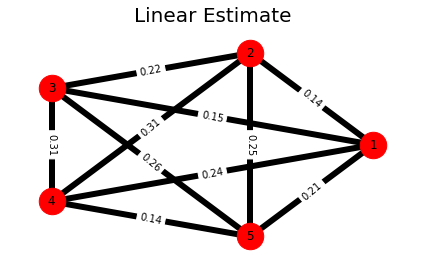

In [16]:
plot_adj_matrix(theta1, 'Linear Estimate', 'Linear_Estimate')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


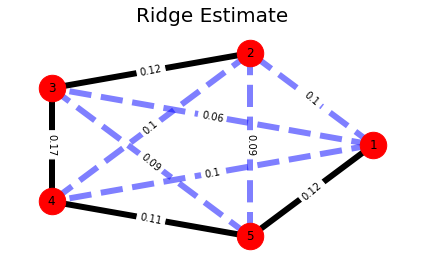

In [17]:
plot_adj_matrix(theta2, 'Ridge Estimate', 'Ridge_Estimate')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


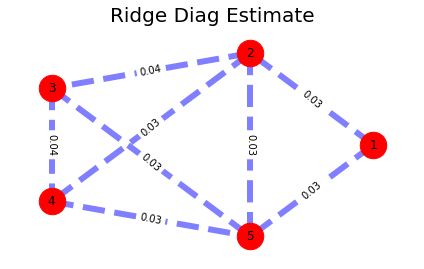

In [18]:
plot_adj_matrix(theta5, 'Ridge Diag Estimate', 'Ridge_Diagonal_Estimate')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


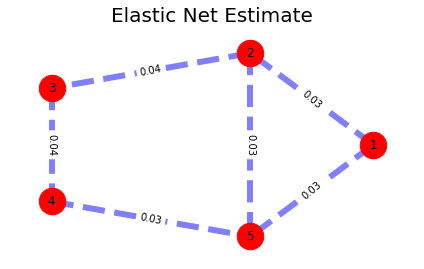

In [19]:
plot_adj_matrix(theta3, 'Elastic Net Estimate', 'Elastic_Net_Estimate')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


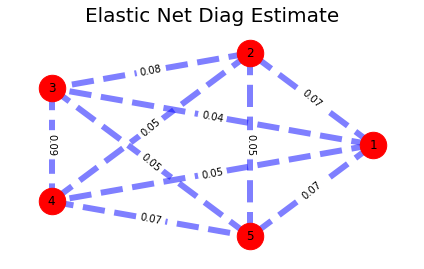

In [20]:
plot_adj_matrix(theta4, 'Elastic Net Diag Estimate', 'Elastic_Net_Diagonal_Estimate')

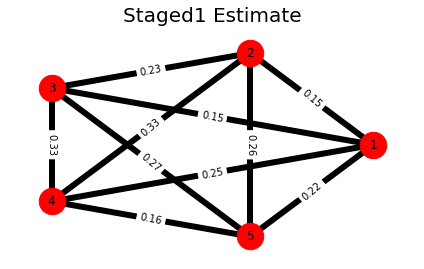

In [21]:
plot_adj_matrix(theta6, 'Staged1 Estimate', 'Staged1_Estimate')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


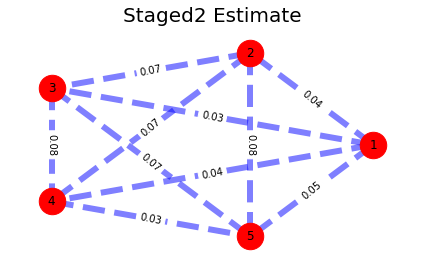

In [22]:
plot_adj_matrix(theta7, 'Staged2 Estimate', 'Staged2_Estimate')

In [24]:
#Table of the results
cycle_table = {' ': ['Linear', 'Ridge', 'Ridge Diag', 'Elastic Net', 'Elastic Net Diag', 'Staged1', 'Staged2'],
               'Train MSE': ['{:.3f}'.format(np.mean(mfull_train)), '{:.3f}'.format(np.mean(mrid_train)),
                             '{:.3f}'.format(np.mean(mridiag_train)),
                                      '{:.3f}'.format(np.mean(mrid_lasso_train)),
                                      '{:.3f}'.format(np.mean(mrid_lasso_diag_train)), '{:.3f}'.format(np.mean(mfix_train)), 
                                      '{:.3f}'.format(np.mean(mstage_train))],
                'Test MSE': ['{:.3f}'.format(np.mean(mfull_test)), '{:.3f}'.format(np.mean(mrid_test)),
                             '{:.3f}'.format(np.mean(mridiag_test)),
                                      '{:.3f}'.format(np.mean(mrid_lasso_test)),
                                      '{:.3f}'.format(np.mean(mrid_lasso_diag_test)), '{:.3f}'.format(np.mean(mfix_test)), 
                                      '{:.3f}'.format(np.mean(mstage_test))],
              'R Diagonal': ['{:.3f}'.format(np.mean(Dfull)), '{:.3f}'.format(np.mean(Drid)), '{:.3f}'.format(np.mean(Dridiag)),
                             '{:.3f}'.format(np.mean(Drid_lasso)),
                                      '{:.3f}'.format(np.mean(Drid_lasso_diag)), '{:.3f}'.format(np.mean(Dfix)), 
                             '{:.3f}'.format(np.mean(Dstage))],
              'R Off diagonal': ['{:.3f}'.format(np.mean(Ofull)), '{:.3f}'.format(np.mean(Orid)), '{:.3f}'.format(np.mean(Oridiag)), 
                                 '{:.3f}'.format(np.mean(Orid_lasso)),
                                      '{:.3f}'.format(np.mean(Orid_lasso_diag)), '{:.3f}'.format(np.mean(Ofix)), 
                                 '{:.3f}'.format(np.mean(Ostage))]}


In [25]:
pd.DataFrame(cycle_table)

,,Train MSE,Test MSE,R Diagonal,R Off diagonal
0,Linear,2.305,14.656,0.133,0.208
1,Ridge,2.727,6.228,0.471,0.100
2,Ridge Diag,2.687,6.099,0.746,0.029
3,Elastic Net,2.702,6.101,0.747,0.027
4,Elastic Net Diag,2.664,6.073,0.661,0.059
5,Staged1,2.337,15.293,0.000,0.219
6,Staged2,2.554,7.523,0.815,0.051


In [114]:
import pandas as pd
table = pd.DataFrame(cycle_table)
table.to_csv('Cycle_simulation_results.csv', index = None)

In [115]:
pd.read_csv('Cycle_simulation_results.csv')

,,Train MSE,Test MSE,R Diagonal,R Off diagonal
0,Linear,2.305,14.656,0.133,0.208
1,Ridge,2.727,6.228,0.471,0.100
2,Ridge Diag,2.687,6.099,0.746,0.029
3,Elastic Net,2.702,6.101,0.747,0.027
4,Elastic Net Diag,2.664,6.073,0.661,0.059
5,Staged1,2.337,15.293,0.000,0.219
6,Staged2,2.554,7.523,0.815,0.051


### Multicollinearity analysis

In [11]:
#Create a reproduction matrix
def theta_creation(d1, M):
    theta=d1 * np.ones([M,M])
    for i in range(M):
        for j in range(M):
            if i != j:
                theta[i,j]=.045*d1
    return theta

In [12]:
offdiag = np.sort(np.random.uniform(0, 1, 100))

In [13]:
theta_list = []
max_eigenvalues_list = []
#List of 100 reproduction matrices
for j in offdiag:
    theta = theta_creation(j, 5)
    theta_list.append(theta)
#Compute the maximum eigenvalues for each matrix and store in the list max_eigenvalues_list
for i in range(len(theta_list)):
    max_eigenvalues_list.append(max(np.linalg.eigvals(theta_list[i])))
max_eigenvalues_list = np.sort(np.real(max_eigenvalues_list))

In [14]:
max_eigenvalues_list

array([0.00986803, 0.02069012, 0.0272446 , 0.03445564, 0.0436456 ,
       0.0490693 , 0.05329457, 0.05552116, 0.0761179 , 0.08845629,
       0.0918532 , 0.11452039, 0.13070129, 0.18068893, 0.2357254 ,
       0.25026447, 0.25231535, 0.26100582, 0.30290332, 0.30344407,
       0.30405262, 0.30975457, 0.31110303, 0.32996813, 0.35302243,
       0.35439541, 0.36438286, 0.366327  , 0.37527807, 0.37647104,
       0.3814751 , 0.39539202, 0.40346779, 0.40362948, 0.43666538,
       0.44454052, 0.44639899, 0.4518236 , 0.45896693, 0.47739792,
       0.47992891, 0.48565539, 0.48717262, 0.49526953, 0.53123274,
       0.55999978, 0.56296527, 0.56810694, 0.56829898, 0.61301694,
       0.61799903, 0.62201109, 0.63074975, 0.63090869, 0.63445217,
       0.63979358, 0.65289258, 0.69389548, 0.70020177, 0.70969911,
       0.73073966, 0.73725827, 0.77455795, 0.78729478, 0.80871502,
       0.81756072, 0.82824742, 0.83181756, 0.8499117 , 0.85240905,
       0.85788113, 0.8672534 , 0.86841291, 0.89848689, 0.90699

In [50]:
N_list = []
X_list = []
#Generate the synthetic data for each matrix and compute the predictor using the linear system created above
for i in range(len(theta_list)):
    N_list.append(mvh_sim(mu, theta_list[i], 0.05, 2.0, T, M)[0])
    X_list.append(create_linear_system(N_list[i], 0.05, 2.0)[1])

In [51]:
from scipy.stats import spearmanr

In [52]:
corr_list = []
max_correlation_list = []
#Compute the maximum correlation for each predictor
for i in range(len(theta_list)):
    corr_list.append(spearmanr(X_list[i]).correlation)
    corr_list[i] = (corr_list[i] + corr_list[i].T)/2
    for k in range(corr_list[i].shape[0]):
        for l in range(corr_list[i].shape[1]):
            if k==l:
                corr_list[i][k,l] = 0
    max_correlation_list.append(np.max(corr_list[i]))

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


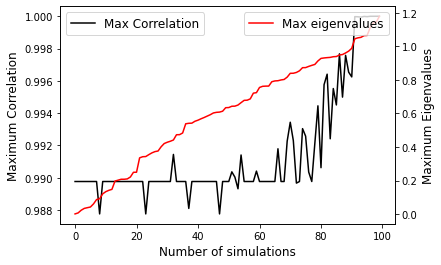

In [49]:
#Plot the maximum correlation and the maximum eigenvalues 
fig, ax=plt.subplots() 
ax2=ax.twinx()

ax.plot(max_correlation_list, 'black', label = 'Max Correlation')
ax2.plot(max_eigenvalues_list, 'r', label = 'Max eigenvalues')
ax.legend(loc='upper left', fontsize = 12)
ax2.legend(loc='upper right', fontsize = 12)
ax.set_xlabel('Number of simulations', fontsize = 12)
ax.set_ylabel('Maximum Correlation', fontsize = 12)
ax2.set_ylabel('Maximum Eigenvalues', fontsize = 12)
plt.savefig('corr_and_eigen.eps')
plt.show()

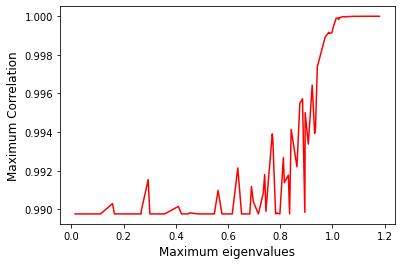

In [53]:
#Plot the max correlations versus the max eigenvalues
plt.plot(max_eigenvalues_list, max_correlation_list, color = 'r')
plt.xlabel('Maximum eigenvalues', fontsize = 12)
plt.ylabel('Maximum Correlation', fontsize = 12)
plt.savefig('corr_vs_eigen.eps')
plt.show()

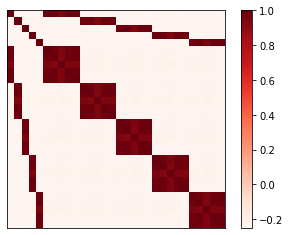

In [48]:
#See the correlation of one of the reproduction matrices (the first in the list) in an map image style
corr_list[0]
np.fill_diagonal(corr_list[0], 1)
#corr_list[0]
plt.imshow(corr_list[0],cmap='Reds')

plt.colorbar()
plt.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)
plt.savefig('multicollinearity_map.eps') 

## MSE analysis 

In [7]:
#Create a reproduction matrix
def theta_creation(d1, M):
    theta=d1 * np.ones([M,M])
    for i in range(M):
        for j in range(M):
            if i != j:
                theta[i,j]=.045*d1
    return theta

In [40]:
offdiag = np.sort(np.random.uniform(0, 1, 100))

In [41]:
theta_list = []
max_eigenvalues_list = []
#List of 100 reproduction matrices
for j in offdiag:
    theta = theta_creation(j, 5)
    theta_list.append(theta)
#Compute the maximum eigenvalues for each matrix and store in the list max_eigenvalues_list
for i in range(len(theta_list)):
    max_eigenvalues_list.append(max(np.linalg.eigvals(theta_list[i])))
max_eigenvalues_list = np.sort(np.real(max_eigenvalues_list))

In [42]:
mse_train_list = []
mse_test_list = []
N_list = []
for i in range(len(theta_list)):
    N_list.append(mvh_sim(mu, theta_list[i], p_est, beta_est, T, M)[0])
    #mse_train_list.append(full_linear_estimate(N_list[i], p_est, beta_est, 7, M)[2]/full_linear_estimate(N_list[i], p_est, beta_est, 7, M)[3])
    mse_train_list.append(full_linear_estimate(N_list[i], p_est, beta_est, 7, M)[2])
    mse_test_list.append(full_linear_estimate(N_list[i], p_est, beta_est, 7, M)[3])

In [43]:
ratio_list = []
for i in range(len(theta_list)):
    ratio_list.append(mse_train_list[i]/mse_test_list[i])
#ratio_list = np.sort(ratio_list)

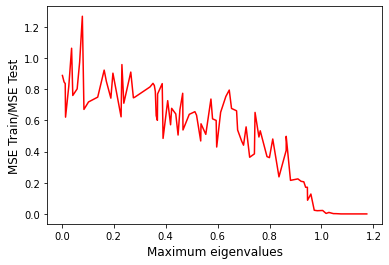

In [44]:
plt.plot(max_eigenvalues_list, ratio_list, color = 'r')
plt.xlabel('Maximum eigenvalues', fontsize = 12)
plt.ylabel('MSE Train/MSE Test', fontsize = 12)
plt.savefig('mseratio_vs_eigen.eps')
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


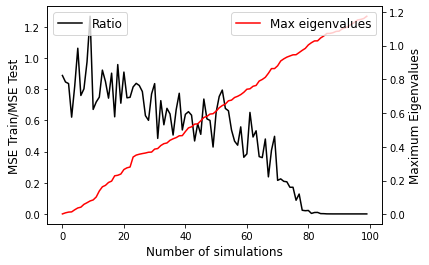

In [45]:
#Plot the maximum correlation and the maximum eigenvalues 
fig, ax=plt.subplots() 
ax2=ax.twinx()

ax.plot(ratio_list, 'black', label = 'Ratio')
ax2.plot(max_eigenvalues_list, 'r', label = 'Max eigenvalues')
ax.legend(loc='upper left', fontsize = 12)
ax2.legend(loc='upper right', fontsize = 12)
ax.set_xlabel('Number of simulations', fontsize = 12)
ax.set_ylabel('MSE Train/MSE Test', fontsize = 12)
ax2.set_ylabel('Maximum Eigenvalues', fontsize = 12)
plt.savefig('mseratio_and_eigen.eps')
plt.show()

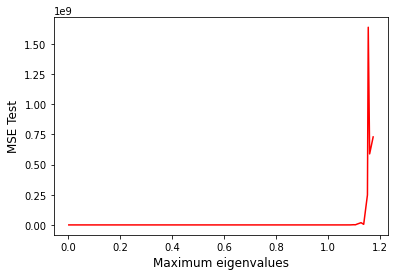

In [49]:
plt.plot(max_eigenvalues_list, mse_test_list, color = 'r')
plt.xlabel('Maximum eigenvalues', fontsize = 12)
plt.ylabel('MSE Test', fontsize = 12)
plt.savefig('msetest_vs_eigen.eps')
plt.show()

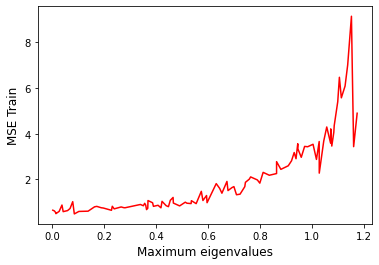

In [50]:
plt.plot(max_eigenvalues_list, mse_train_list, color = 'r')
plt.xlabel('Maximum eigenvalues', fontsize = 12)
plt.ylabel('MSE Train', fontsize = 12)
plt.savefig('msetrain_vs_eigen.eps')
plt.show()